In [1]:
import math
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, utils
import torchvision
from tqdm import tqdm
import numpy as np

from efficient_kan.kan import KAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from torchkan.KANvolver import KANvolver as kanv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [2]:
"""
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
train_subset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
"""
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#  Train set. Here we sort the CIFAR10 by class and disable data shuffling
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset)), key=lambda idx: train_dataset.targets[idx])
train_subset = Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

"""
# MultiTask training sets
train_loader_tasks = []
indices=[]
for k in range(5):
    indices.append(list(
        filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(
        DataLoader(torch.utils.data.Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))
"""
# Multi-task training sets
train_loader_tasks = []
indices = []
for k in range(5):
    indices.append(list(
        filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(
        DataLoader(Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))
"""
# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)
"""
# Test set
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_subset = Subset(test_dataset, range(len(test_dataset)))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:12<00:00, 13352097.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Class 0


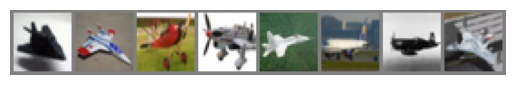

Class 1


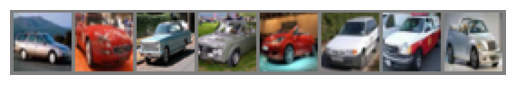

Class 2


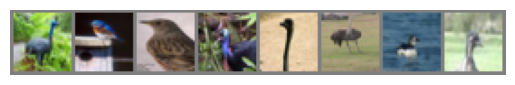

Class 3


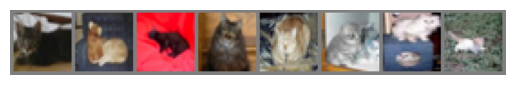

Class 4


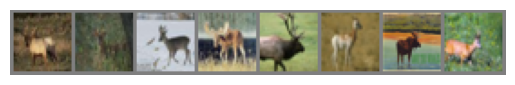

Class 5


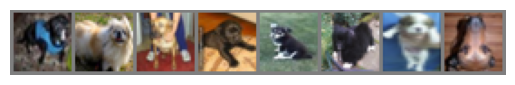

Class 6


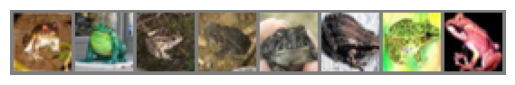

Class 7


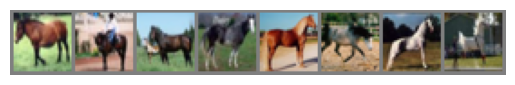

Class 8


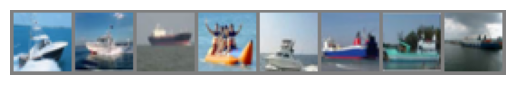

Class 9


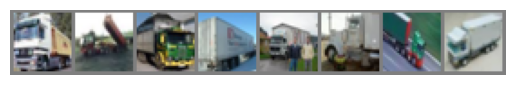

In [8]:
# Print image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display a batch of images from a specific class
def show_images(class_index, num_images=8):
    class_indices = [i for i, label in enumerate(train_dataset.targets) if label == class_index]
    subset_indices = class_indices[:num_images]
    class_subset = Subset(train_dataset, subset_indices)
    class_loader = DataLoader(class_subset, batch_size=num_images, shuffle=False)

    dataiter = iter(class_loader)
    images, labels = next(dataiter)
    imshow(utils.make_grid(images))

for class_index in range(10):
    print(f"Class {class_index}")
    show_images(class_index)

# ARCHITECTURES DEFINITION

In [ ]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# KAN
class KAN_small(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 128, 10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)


class KAN_big(nn.Module):
    def __init__(self, device=device):
        super(KAN_big, self).__init__()
        self.model = KAN([28 * 28, 28 * 28, 128, 10]).to(device)

    def forward(self, x):
        return self.model(x)

In [ ]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [ ]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
# Conv2d + MLP + (Dropout)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        #x = F.log_softmax(x, dim=1)
        return x

In [ ]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
# Conv2d + MLP
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
# KANvolver
class KANvolver(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KANvolver, self).__init__()
        self.model = kanv([10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)

# TRAIN() AND TEST() FUNCTIONS

In [ ]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=train_loader,
          task_id=None):
    criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        losses = []
        accuracies = []
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                    images = images.view(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, losses, accuracies, epoch_duration, lr, task_id)
        # torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [ ]:
def test(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                images = images.view(-1, 28 * 28)
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# INTRA and INTER DATASET TESTS

In [ ]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir='checkpoint_intra/stats/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)
        # return [pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
        #         filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))]

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir='checkpoint_intra/stats/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_losses, train_accuracies, epoch_duration, lr, task_id):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_losses[-1], test_loss, labels, predictions, epoch_duration,
                     lr, train_losses, train_accuracies, task_id)
    stat.save(
        dir=f'checkpoint_intra/stats/lr_{round(math.log10(lr))}/' if task_id is None else f'checkpoint_inter/stats/lr_{round(math.log10(lr))}/')

## INTRA DATASET TEST

In [ ]:
for lr in [1e-3,1e-4, 1e-5, 1e-6, 1e-7][2:3]:
    models = [MLP(), KAN_small(),
              CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
              KKAN_Convolutional_Network(), SimpleCNN(),KANvolver()]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[2:-1]]:
        print(f'Training model={model.__class__.__name__}')
        # lr = 1e-5 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-4
        train(model, f'checkpoint_intra/{model.__class__.__name__}', epochs=30, start_epoch=0,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

## INTER DATASET TEST

In [ ]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          # ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
for model in [x.to(device) for x in models[-1:]]:
    print(f'Training model={model.__class__.__name__}')
    lr = 1e-7 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-6
    for i, task in enumerate(train_loader_tasks):
        print(f'Training on task {i}')
        epochs = 6
        train(model, f'checkpoint_inter/{model.__class__.__name__}', epochs=epochs, start_epoch=i * epochs,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr, loader=task, task_id=i)

Training model=KANvolver
Training on task 0


 99%|█████████▉| 196/198 [00:03<00:00, 54.03it/s, accuracy=0.328, loss=2.1, lr=1e-6] C:\Users\MrPio\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 198/198 [00:03<00:00, 49.72it/s, accuracy=0.421, loss=2.06, lr=1e-6]


Epoch 1, Loss: 2.055217981338501
Accuracy: 0.2282046178343949


100%|██████████| 198/198 [00:03<00:00, 50.92it/s, accuracy=0.404, loss=2.06, lr=1e-6]


Epoch 2, Loss: 2.055370330810547
Accuracy: 0.24402866242038215


100%|██████████| 198/198 [00:03<00:00, 51.24it/s, accuracy=0.474, loss=1.98, lr=1e-6]


Epoch 3, Loss: 1.9845646619796753
Accuracy: 0.24820859872611464


100%|██████████| 198/198 [00:03<00:00, 51.01it/s, accuracy=0.456, loss=1.99, lr=1e-6]


Epoch 4, Loss: 1.9911162853240967
Accuracy: 0.257265127388535


100%|██████████| 198/198 [00:03<00:00, 50.93it/s, accuracy=0.404, loss=1.94, lr=1e-6]


Epoch 5, Loss: 1.9446159601211548
Accuracy: 0.258359872611465


100%|██████████| 198/198 [00:03<00:00, 50.40it/s, accuracy=0.544, loss=1.96, lr=1e-6]


Epoch 6, Loss: 1.961045265197754
Accuracy: 0.2713972929936306
Training on task 1


100%|██████████| 189/189 [00:03<00:00, 49.69it/s, accuracy=0.193, loss=2.25, lr=1e-6] 


Epoch 7, Loss: 2.2459166049957275
Accuracy: 0.29956210191082805


100%|██████████| 189/189 [00:03<00:00, 50.95it/s, accuracy=0.175, loss=2.21, lr=1e-6]


Epoch 8, Loss: 2.209367275238037
Accuracy: 0.31210191082802546


100%|██████████| 189/189 [00:03<00:00, 49.69it/s, accuracy=0.123, loss=2.17, lr=1e-6]


Epoch 9, Loss: 2.1716158390045166
Accuracy: 0.31389331210191085


100%|██████████| 189/189 [00:03<00:00, 51.69it/s, accuracy=0.228, loss=2.2, lr=1e-6] 


Epoch 10, Loss: 2.2035393714904785
Accuracy: 0.3186703821656051


100%|██████████| 189/189 [00:03<00:00, 50.73it/s, accuracy=0.404, loss=2.05, lr=1e-6]


Epoch 11, Loss: 2.054429769515991
Accuracy: 0.3358877388535032


100%|██████████| 189/189 [00:03<00:00, 49.22it/s, accuracy=0.404, loss=2.04, lr=1e-6]


Epoch 12, Loss: 2.0430891513824463
Accuracy: 0.33807722929936307
Training on task 2


100%|██████████| 176/176 [00:03<00:00, 49.50it/s, accuracy=0.222, loss=2.18, lr=1e-6]


Epoch 13, Loss: 2.1817049980163574
Accuracy: 0.31757563694267515


100%|██████████| 176/176 [00:03<00:00, 50.44it/s, accuracy=0.19, loss=2.24, lr=1e-6] 


Epoch 14, Loss: 2.2418229579925537
Accuracy: 0.3150875796178344


100%|██████████| 176/176 [00:03<00:00, 48.76it/s, accuracy=0.317, loss=2.05, lr=1e-6]


Epoch 15, Loss: 2.0483529567718506
Accuracy: 0.3021496815286624


100%|██████████| 176/176 [00:03<00:00, 48.92it/s, accuracy=0.27, loss=2.06, lr=1e-6] 


Epoch 16, Loss: 2.060286283493042
Accuracy: 0.30065684713375795


100%|██████████| 176/176 [00:03<00:00, 50.28it/s, accuracy=0.365, loss=2.07, lr=1e-6]


Epoch 17, Loss: 2.068053722381592
Accuracy: 0.2884156050955414


100%|██████████| 176/176 [00:03<00:00, 51.18it/s, accuracy=0.349, loss=2.09, lr=1e-6]


Epoch 18, Loss: 2.085224151611328
Accuracy: 0.2650278662420382
Training on task 3


100%|██████████| 191/191 [00:03<00:00, 50.42it/s, accuracy=0.217, loss=2.12, lr=1e-6] 


Epoch 19, Loss: 2.1177778244018555
Accuracy: 0.3187699044585987


100%|██████████| 191/191 [00:03<00:00, 48.99it/s, accuracy=0.391, loss=2.01, lr=1e-6]


Epoch 20, Loss: 2.0093555450439453
Accuracy: 0.32245222929936307


100%|██████████| 191/191 [00:03<00:00, 50.15it/s, accuracy=0.261, loss=2.11, lr=1e-6]


Epoch 21, Loss: 2.1077311038970947
Accuracy: 0.3362858280254777


100%|██████████| 191/191 [00:03<00:00, 51.61it/s, accuracy=0.348, loss=1.99, lr=1e-6]


Epoch 22, Loss: 1.989743947982788
Accuracy: 0.31289808917197454


100%|██████████| 191/191 [00:03<00:00, 52.74it/s, accuracy=0.348, loss=1.95, lr=1e-6]


Epoch 23, Loss: 1.9544003009796143
Accuracy: 0.3326035031847134


100%|██████████| 191/191 [00:03<00:00, 51.45it/s, accuracy=0.348, loss=1.97, lr=1e-6]


Epoch 24, Loss: 1.972805380821228
Accuracy: 0.3112062101910828
Training on task 4


100%|██████████| 185/185 [00:03<00:00, 49.81it/s, accuracy=0.0417, loss=2.24, lr=1e-6]


Epoch 25, Loss: 2.242227554321289
Accuracy: 0.3271297770700637


100%|██████████| 185/185 [00:03<00:00, 50.35it/s, accuracy=0.125, loss=2.17, lr=1e-6] 


Epoch 26, Loss: 2.1749632358551025
Accuracy: 0.32931926751592355


100%|██████████| 185/185 [00:03<00:00, 49.36it/s, accuracy=0.167, loss=2.11, lr=1e-6]


Epoch 27, Loss: 2.112744092941284
Accuracy: 0.33369824840764334


100%|██████████| 185/185 [00:03<00:00, 50.00it/s, accuracy=0.292, loss=2.05, lr=1e-6]


Epoch 28, Loss: 2.046816110610962
Accuracy: 0.3232484076433121


100%|██████████| 185/185 [00:03<00:00, 49.64it/s, accuracy=0.375, loss=2.03, lr=1e-6]


Epoch 29, Loss: 2.0316545963287354
Accuracy: 0.3196656050955414


100%|██████████| 185/185 [00:03<00:00, 52.59it/s, accuracy=0.25, loss=2.25, lr=1e-6] 


Epoch 30, Loss: 2.2466652393341064
Accuracy: 0.32434315286624205


# RESULTS PLOTTING

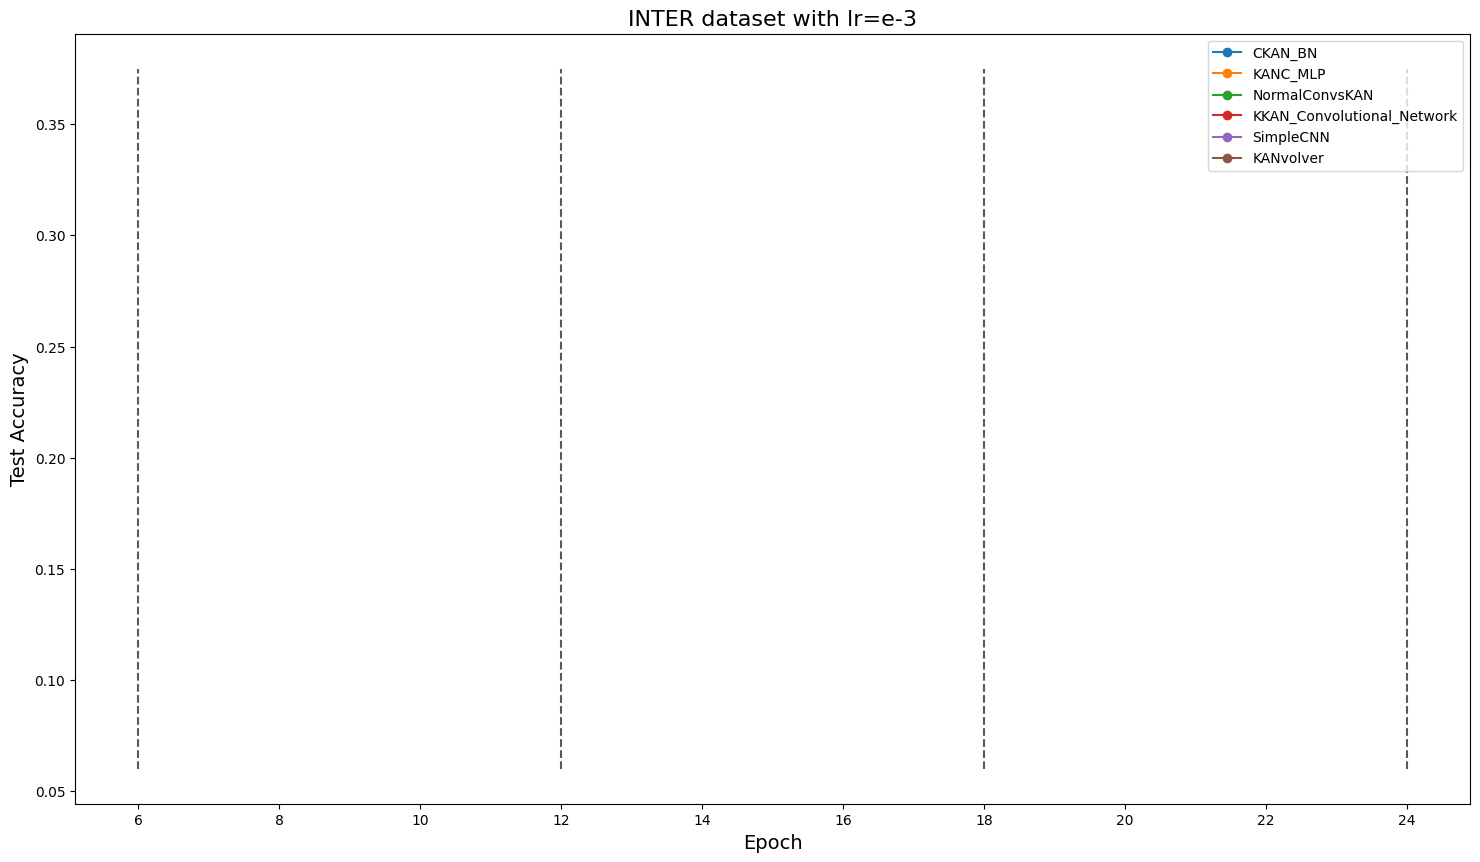

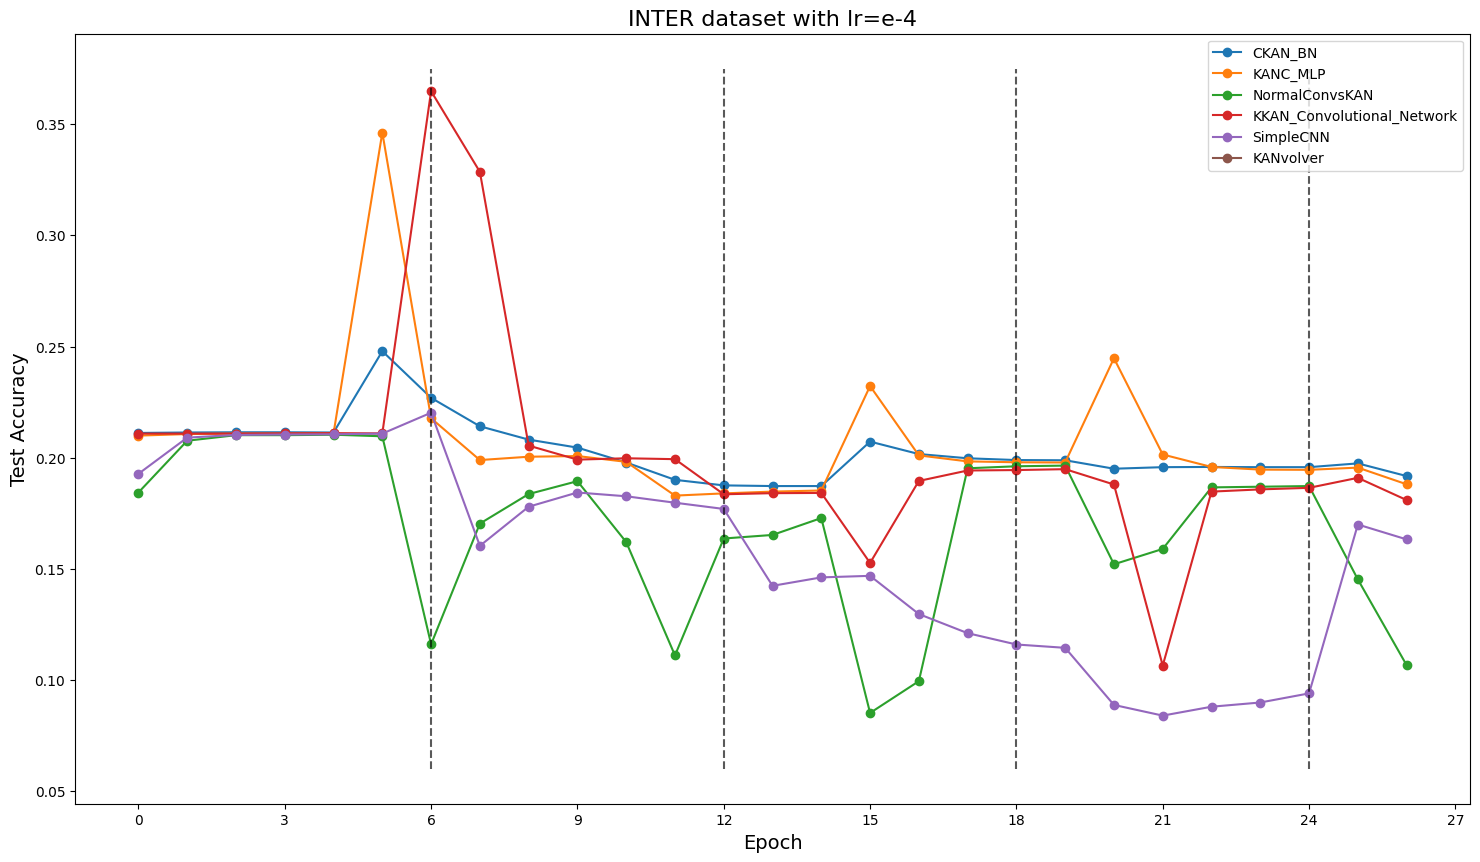

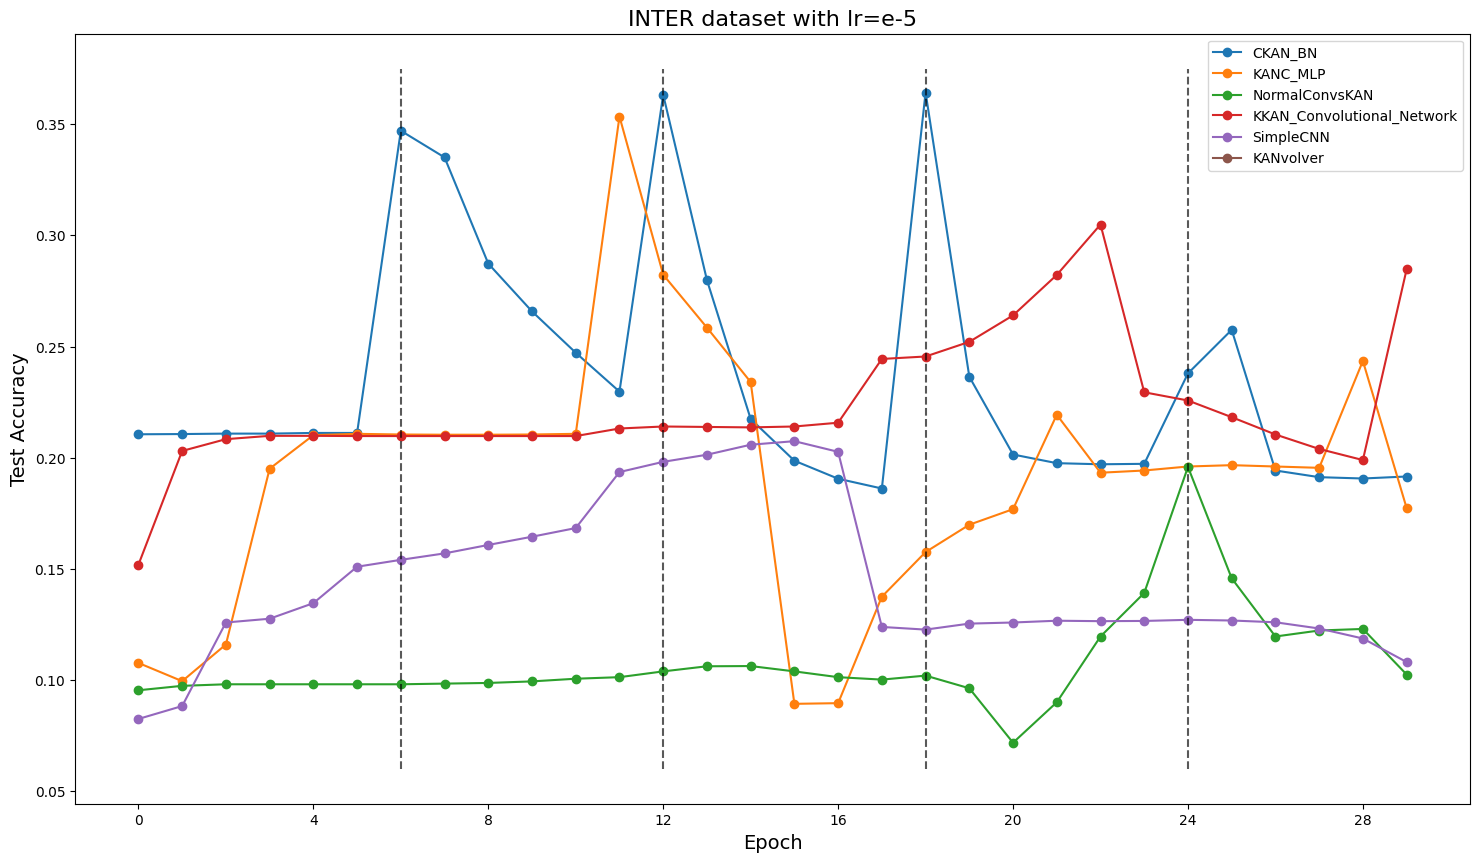

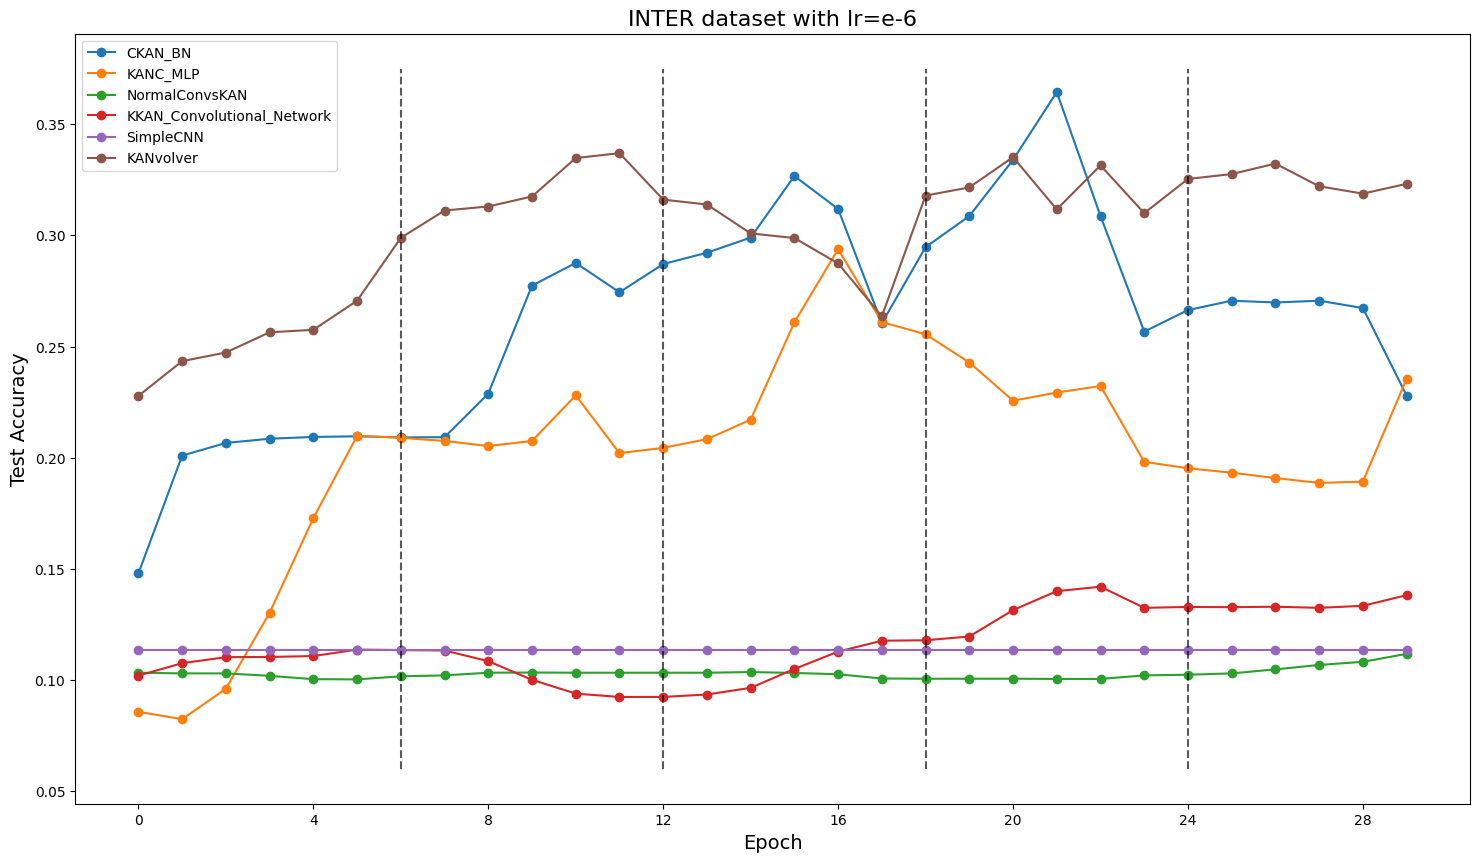

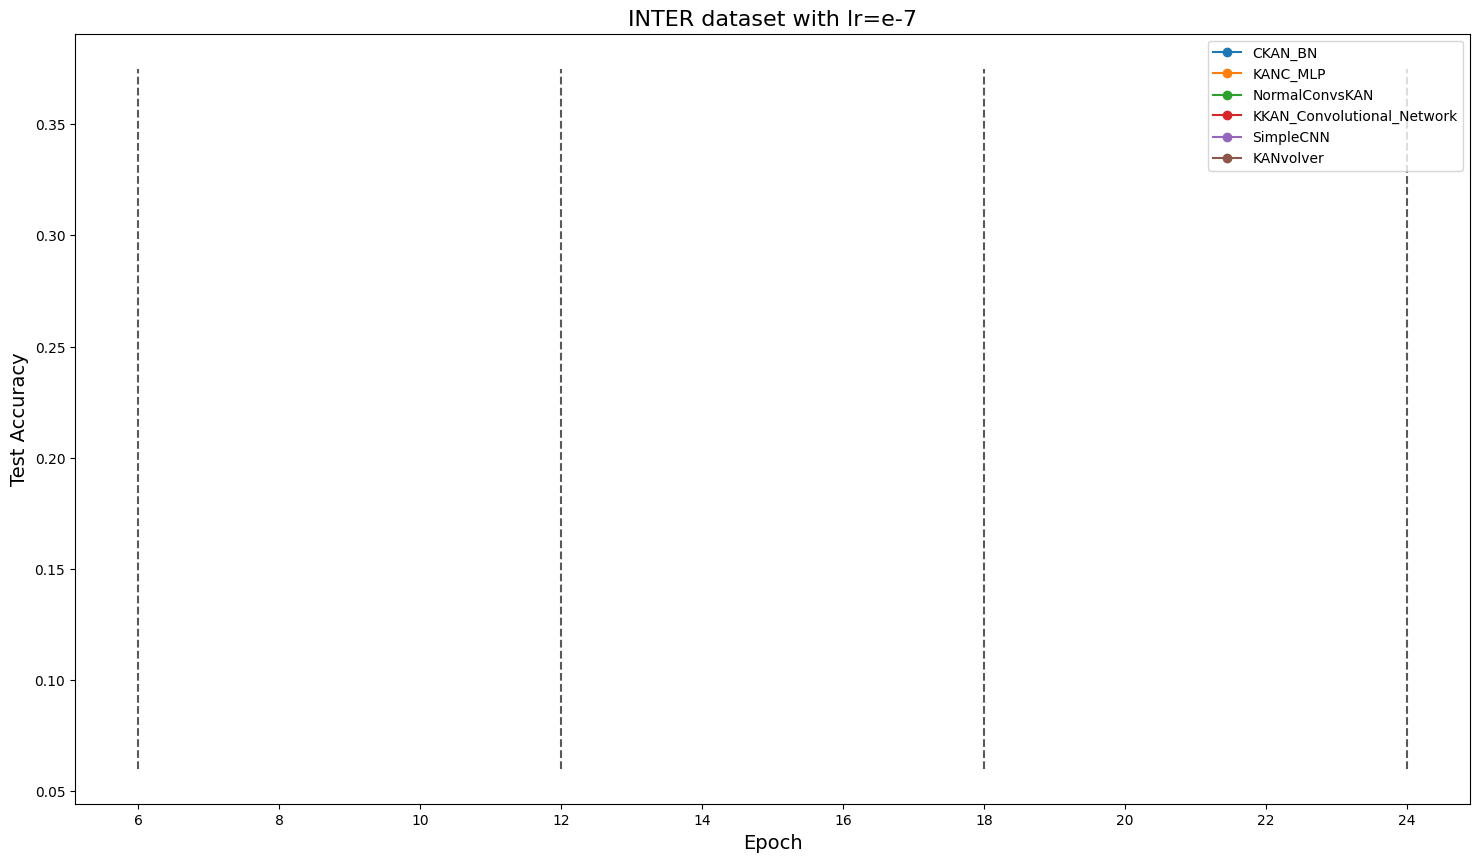

In [ ]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          KKAN_Convolutional_Network(), SimpleCNN(),KANvolver()]
for lr in [1e-3,1e-4,1e-5,1e-6,1e-7]:
    fig, ax = plt.subplots()
    batches = [
        0,
        5923,
        6742,
        5958,
        6131,
        5842,
        5421,
        5918,
        6265,
        5851,
        # 5949,
    ]
    granularity = 1
    for name in list(map(lambda e: e.__class__.__name__, models[2:])):
        stats = EpochStat.loadModelStats(name, dir='checkpoint_inter/stats/', subdir=f'lr_{round(math.log10(lr))}/')
        ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name, marker='o')
        # ax.plot(list(map(lambda e: e.train_accuracies, stats))[0][::granularity], label=name)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_xticks([x // 64 // granularity for x in itertools.accumulate(batches)])
    # ax.set_xticklabels(range(10))
    # plt.vlines(x=[x // 64 // granularity for x in itertools.accumulate(batches)], ymin=0, ymax=1, colors='black',
    #            alpha=0.65, linestyles='dashed')
    # plt.xlabel('Train Digits Batches', fontdict={'fontsize': 14})
    # plt.ylabel('Train batch Loss', fontdict={'fontsize': 14})
    # plt.title('Train batch loss spikes show up when a new digit is submitted', fontdict={'fontsize': 16})
    plt.xlabel('Epoch', fontdict={'fontsize': 14})
    plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
    plt.title(f'INTER dataset with lr=e{round(math.log10(lr))}', fontdict={'fontsize': 16})
    plt.vlines(x=range(0, 30,6)[1:], ymin=0.06, ymax=0.375, colors='black',alpha=0.65, linestyles='dashed')
    fig.set_size_inches(18, 10)
    plt.show()

## CONFUSION MATRICES PLOTTING

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
plt.rc('font', size=18)
for name in list(map(lambda e: e.__class__.__name__, models[:2])):
    stats = EpochStat.loadModelStats(name, dir='checkpoint_inter/stats/', subdir='')
    for stat in stats[:]:
        cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
        disp.plot()
        fig = disp.ax_.get_figure()
        fig.set_figwidth(8)
        fig.set_figheight(8)
        plt.figtext(0.445, 0.85, f'{name.replace("KAN_small", "KAN")} Epoch: {stat.epoch}', ha='center', fontsize=22)
        fig.savefig(f'png/inter/lr_-6/{name} ep{stat.epoch}.png')